In [21]:
%load_ext autoreload
%autoreload 2
import os, sys
# os.environ['PROXY_URL'] = ''
from trade.helpers.Context import Context
from trade.helpers.helper import change_to_last_busday, is_USholiday, retrieve_timeseries, find_split_dates_within_range
from scipy.stats import percentileofscore
from _strategy.trend.bbands import LongBBandsTrend, LongBBandsTrend_SL
import pandas as pd
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
from datetime import datetime
import yfinance as yf
import numpy as np
from scipy.stats import norm, skew, kurtosis
from trade.helpers.Logging import setup_logger
from trade.assets.Stock import Stock
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas_ta as ta
from trade.backtester_.utils.aggregators import dd, mdd, cagr
from wfa.aggregator import Aggregator, MonteCarloBacktest, BaseAggregator, median_dd
from wfa.utils import load_result_dict, results_dict, get_equity_tick
import statsmodels.api as sm
from dbase.DataAPI.ThetaData import retrieve_quote, list_contracts, retrieve_eod_ohlc
import statsmodels.formula.api as smf  
logger = setup_logger('Opt_WFA_Analysis')
pd.options.plotting.backend = 'plotly'
pd.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## To check:
- Sanity Checks:
    - Yearly aggregates
    - Aggregates
    - Trades
    - Comparing trades and equity moves
    - Monte Carlo Backtest

In [3]:
load_result_dict('OPTION', 'BASE', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/base.pkl')
load_result_dict('OPTION', 'ZSCORE_1NORM', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/vol_zscore_1scale.pkl')
load_result_dict('OPTION', 'ZSCORE_2NORM', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/vol_zscore_2scale.pkl')
    



Scheduled Data Requests will be saved to: /Users/chiemelienwanisobi/cloned_repos/QuantTools/module_test/raw_code/DataManagers/scheduler/requests.jsonl
2025-06-27 15:03:53 trade.asset.Stock ERROR: Error getting previous close for BA from yfinance: 'prev_close'
2025-06-27 15:03:54 trade.asset.Stock ERROR: Error getting dividends history for AMD from yfinance
2025-06-27 15:03:54 trade.asset.Stock ERROR: Probably due to no dividends history
2025-06-27 15:03:59 trade.asset.Stock ERROR: Error getting dividends history for NFLX from yfinance
2025-06-27 15:03:59 trade.asset.Stock ERROR: Probably due to no dividends history
2025-06-27 15:04:04 trade.asset.Stock ERROR: Error getting previous close for AMZN from yfinance: 'prev_close'
2025-06-27 15:04:07 trade.asset.Stock ERROR: Error getting dividends history for TSLA from yfinance
2025-06-27 15:04:07 trade.asset.Stock ERROR: Probably due to no dividends history
2025-06-27 15:04:08 trade.asset.Stock ERROR: Error getting dividends history for A

In [13]:
class EVBOptionAggregator(BaseAggregator):

    def __init__(self,                  
                 results = None,
                 optimization = 'TARGET_OPTIMIZATION',
                 target = 'RETURN',):
        super().__init__(results, optimization, target)
        self.symbol_list = self.set_symbol_list(min(self.backtesters.keys()))
        
    def get_port_stats(self):
        return True
    
    def get_wfa_window_stats(self):
        return True
    
    def set_symbol_list(self, index):
        self.symbol_list = self.backtesters[index].portfolio.symbol_list

    def get_all_trades(self):
        trades = super().get_all_trades()
        trades.rename(columns = {'EntryQuantity': 'Size'}, inplace=True)
        return trades

    def dates_(self, start: bool = True):
        if start:
            return self._equity.index.min()
        else:
            return self._equity.index.max()
    
    def buyNhold(self):
        return 0
    
    def aggregate(self):
        agg =  super().aggregate()
        agg = agg.drop('Buy & Hold Return [%]')
        return agg
        


option_aggregator_base = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'BASE')

option_aggregator_zscore1 = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'ZSCORE_1NORM')

option_aggregator_zscore2 = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'ZSCORE_2NORM')

option_aggregator_base

In [29]:
option_aggregator_zscore2.yearly_agg()

,Return [%],Vol Annualized [%],Sharpe,Max DrawDown [%],Max DrawDown Duration,#Trades,Win Rate [%],Expectancy [%],95 Quantile ($),5 Quantile ($),95 Quantile (%),5 Quantile (%)
datetime,,,,,,,,,,,,
2017,1.50,0.81,1.49,-31.63,49 days,26.00,61.54,54.66,"3,503.70","-3,648.70",0.09,-0.08
2018,0.34,1.01,0.74,-48.10,194 days,25.00,40.00,12.50,"6,412.52","-8,288.25",0.08,-0.09
2019,0.29,0.64,0.63,-23.75,132 days,20.00,35.00,16.15,"4,185.88","-4,324.25",0.07,-0.06
2020,4.66,1.95,1.81,-61.21,80 days,38.00,63.16,47.25,"46,524.75","-45,606.68",0.18,-0.14
2021,0.59,2.07,1.15,-51.69,215 days,32.00,43.75,23.42,"94,911.71","-77,537.32",0.18,-0.16
2022,-0.23,1.21,0.36,-49.89,277 days,18.00,22.22,-19.13,"90,204.48","-94,079.40",0.13,-0.12
2023,1.63,2.17,1.49,-57.39,151 days,29.00,51.72,23.65,"233,743.50","-223,260.80",0.24,-0.16
2024,1.18,3.76,1.79,-64.40,76 days,30.00,60.00,39.29,"921,385.37","-1,097,514.27",0.41,-0.28
2025,0.15,0.83,1.33,-21.01,33 days,7.00,71.43,11.09,"436,559.60","-344,857.48",0.10,-0.07


In [23]:
option_aggregator_base.yearly_agg()

,Return [%],Vol Annualized [%],Sharpe,Max DrawDown [%],Max DrawDown Duration,#Trades,Win Rate [%],Expectancy [%],95 Quantile ($),5 Quantile ($),95 Quantile (%),5 Quantile (%)
datetime,,,,,,,,,,,,
2017,1.52,0.76,1.54,-27.25,41 days,26.00,61.54,52.81,"2,985.53","-2,916.45",0.08,-0.07
2018,0.21,0.96,0.63,-47.81,194 days,25.00,40.00,9.59,"5,570.52","-7,335.80",0.08,-0.08
2019,0.12,0.58,0.39,-25.41,141 days,20.00,35.00,14.76,"3,475.25","-3,894.40",0.06,-0.07
2020,4.12,2.05,1.76,-63.47,80 days,38.00,63.16,46.48,"33,680.15","-33,380.00",0.20,-0.15
2021,0.44,1.99,1.10,-53.54,215 days,32.00,46.88,21.25,"70,001.29","-52,100.62",0.20,-0.16
2022,-0.25,1.20,0.34,-49.95,277 days,18.00,22.22,-19.59,"59,396.25","-66,684.25",0.13,-0.12
2023,2.07,2.84,1.66,-73.47,151 days,29.00,51.72,25.12,"203,109.40","-192,727.12",0.32,-0.22
2024,0.91,4.04,1.82,-67.62,76 days,30.00,63.33,36.74,"679,246.37","-879,283.11",0.46,-0.30
2025,0.24,0.87,1.83,-19.93,33 days,7.00,71.43,13.78,"304,735.50","-241,926.93",0.09,-0.07


In [16]:
option_aggregator_zscore1.plot_portfolio()

In [17]:
option_aggregator_base.plot_portfolio()

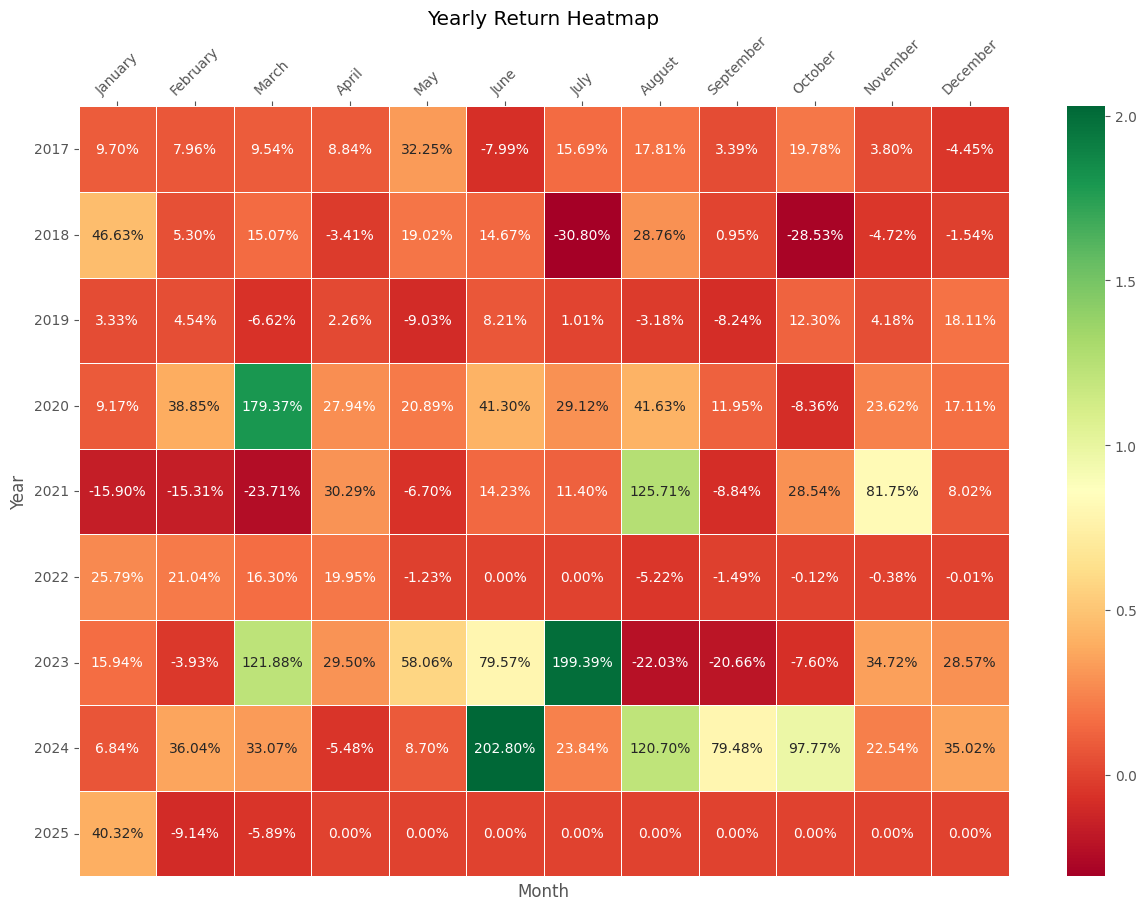

,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2017,0.097008,0.079614,0.095412,0.088363,0.322516,-0.079853,0.156858,0.178131,0.033948,0.197829,0.038008,-0.044524
2018,0.466258,0.053031,0.150655,-0.034082,0.190226,0.146677,-0.308033,0.287572,0.009497,-0.285274,-0.047198,-0.015372
2019,0.033326,0.045380,-0.066173,0.022625,-0.090278,0.082105,0.010087,-0.031785,-0.082383,0.122981,0.041846,0.181089
2020,0.091697,0.388511,1.793730,0.279422,0.208874,0.413006,0.291223,0.416288,0.119468,-0.083625,0.236230,0.171129
2021,-0.158968,-0.153063,-0.237141,0.302888,-0.066958,0.142336,0.114014,1.257053,-0.088399,0.285397,0.817464,0.080250
2022,0.257946,0.210421,0.163036,0.199538,-0.012259,0.000000,0.000000,-0.052177,-0.014859,-0.001204,-0.003827,-0.000122
2023,0.159441,-0.039307,1.218846,0.294962,0.580578,0.795743,1.993935,-0.220328,-0.206635,-0.075983,0.347212,0.285727
2024,0.068362,0.360427,0.330663,-0.054782,0.087048,2.028027,0.238447,1.206994,0.794817,0.977723,0.225404,0.350163
2025,0.403249,-0.091444,-0.058913,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [40]:
option_aggregator.yearly_performance(True)

In [24]:
opt_agg_zscore2 = option_aggregator_zscore2.aggregate()
opt_agg_zscore2

Start                                                    2017-01-05 00:00:00
End                                                      2025-03-03 00:00:00
Duration                                                  2979 days 00:00:00
Exposure Time [%]                                                     100.00
Equity Final [$]                                                4,208,470.69
Equity Peak [$]                                                 5,327,646.74
Return [%]                                                         21,540.93
CAGR [%]                                                               93.25
Volatility Ann. [%]                                                   193.38
Sharpe Ratio                                                            1.22
Sortino Ratio                                                           1.91
Skew                                                                    2.59
Log Return Skew                                                        -0.38

In [25]:
opt_agg_base = option_aggregator_base.aggregate()
opt_agg_base

Start                                                    2017-01-05 00:00:00
End                                                      2025-03-03 00:00:00
Duration                                                  2979 days 00:00:00
Exposure Time [%]                                                     100.00
Equity Final [$]                                                3,123,689.73
Equity Peak [$]                                                 3,995,147.06
Return [%]                                                         15,983.32
CAGR [%]                                                               86.35
Volatility Ann. [%]                                                   209.59
Sharpe Ratio                                                            1.23
Sortino Ratio                                                           1.97
Skew                                                                    3.05
Log Return Skew                                                        -0.33

In [45]:
option_aggregator_zscore2.backtesters[12].portfolio.unprocessed_signals

[]

In [34]:
dir(option_aggregator_zscore2.backtesters[4].risk_manager.sizer)

['CASH_USE_RULES',
 'VOL_TYPES',
 '_BaseSizer__CASH_USE_RULES',
 '_ZscoreRVolSizer__rolling_window',
 '_ZscoreRVolSizer__rvol_window',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 'calculate_position_size',
 'calculate_scaler',
 'cash_rule',
 'daily_update',
 'delta_limit_log',
 'get_cash',
 'get_daily_delta_limit',
 'load_rvol_timeseries',
 'log_daily_delta_limit',
 'norm_constant',
 'pm',
 'position_id_starting_cash',
 'post_analyze_task',
 'pre_analyze_task',
 're_update_on_roll',
 'register_position_id_starting_cash',
 'register_signal_starting_cash',
 'rm',
 'rolling_window',
 'rvol_timeseries

In [36]:
option_aggregator._trades.sort_values(by = 'ReturnPct').iloc[1]

TradeID              &L:AMD20250117C270&S:AMD20250117C280
SignalID                                  AMD20240104LONG
Ticker                                                AMD
EntryTime                             2024-03-06 00:00:00
ExitTime                              2024-05-03 00:00:00
EntryPrice                                       238.7303
EntryCommission                                    2437.5
EntrySlippage                                23306.812254
Size                                                 1875
EntryAuxilaryCost                            25744.312254
TotalEntryCost                              447619.312254
ExitPrice                                       37.162266
ExitCommission                                     2437.5
ExitSlippage                                 -1945.751772
ExitQuantity                                         1875
ExitAuxilaryCost                              4383.251772
TotalExitCost                                69679.248228
Quantity      

In [38]:
dummy_rm.position_data['&L:AMD20250117C270&S:AMD20250117C280'].loc['2024-03-06':].Midpoint.plot()

In [39]:
dummy_rm.position_data['&L:SBUX20220520C145&S:SBUX20220520C150'].loc['2021-07-23':].Midpoint_skip_day.plot()

In [12]:
option_aggregator.plot_portfolio()

In [56]:
from scipy.stats.mstats import winsorize
historical_eq = option_aggregator_zscore2._equity['Total']
smoothed_eq = option_aggregator_zscore2._equity['Total'].ewm(span =1).mean()

# historical_returns = smoothed_eq.pct_change(periods = 1).dropna()
historical_returns = np.log(smoothed_eq/smoothed_eq.shift(1)).dropna()
monte_smooth = MonteCarloBacktest(returns = historical_returns, 
                           initial_price  = 20000, 
                           size = 252*10, 
                           num_simulations = 1000,
                           log = True)
summary_smooth = monte_smooth.summary(0.5)
summary_smooth

## Add median CAGR
## Median Vol
## Median Sharpe
## Median Skew

Ruin                                      69.60%
Median Drawdown                          -99.09%
Worst Drawdown                          -100.00%
Median Vol Annualized                    197.67%
Median $ Profit                      17077790.37
Median Return                          86581.07%
Median CAGR                              166.50%
Median Skew                                 2.50
Return/DD                                   1.68
Prob>0                                    87.60%
Median Var95                       4630694451.73
Median Var05                      -3657619249.10
Best Case Final Equity (95%)     273851412398.92
Worst Case Final Equity (05%)            1039.36
dtype: object

In [58]:

from EventDriven.riskmanager.utils import add_skip_columns
from scipy.stats.mstats import winsorize

equity2 = option_aggregator_zscore2._equity.copy()
equity2 = add_skip_columns(
    equity2, 
    'IGNORE',
    ['Total'],
    15,
    2.75

)

equity2['ffwd_total'] = equity2.Total
equity2.loc[equity2.Total_skip_day == True, 'ffwd_total'] = np.nan
equity2.ffwd_total.fillna(method = 'ffill', inplace = True)


log_returns = np.log(equity2.ffwd_total/ equity2.ffwd_total.shift(1)).dropna()
clipped_returns = winsorize(log_returns, limits=[0.01, 0.01])


monte_winsorize_skip = MonteCarloBacktest(returns = clipped_returns, 
                           initial_price  = 20000, 
                           size = 252*10, 
                           num_simulations = 2500,
                           log = True)
summary_winsorize_skip = monte_winsorize_skip.summary(cutoff = 0.5)
summary_winsorize_skip


Ruin                                    30.32%
Median Drawdown                        -82.83%
Worst Drawdown                         -99.74%
Median Vol Annualized                   91.73%
Median $ Profit                    14918568.95
Median Return                        75853.31%
Median CAGR                            161.45%
Median Skew                               0.44
Return/DD                                 1.95
Prob>0                                  99.16%
Median Var95                       16702135.05
Median Var05                      -11638745.63
Best Case Final Equity (95%)     1530956090.68
Worst Case Final Equity (05%)        125388.03
dtype: object

In [53]:

from EventDriven.riskmanager.utils import add_skip_columns
equity2 = option_aggregator_zscore2._equity.copy()
equity2 = add_skip_columns(
    equity2, 
    'IGNORE',
    ['Total'],
    15,
    2.75

)

equity2['ffwd_total'] = equity2.Total
equity2.loc[equity2.Total_skip_day == True, 'ffwd_total'] = np.nan
equity2.ffwd_total.fillna(method = 'ffill', inplace = True)
# equity2.ffwd_total.plot()


from scipy.stats.mstats import winsorize
historical_eq = equity2.ffwd_total

historical_returns = historical_eq.pct_change(periods = 1).dropna()
monte_ffwd = MonteCarloBacktest(returns = historical_returns, 
                           initial_price  = 20000, 
                           size = 252*10, 
                           num_simulations = 2500)
summary_ffwd = monte_ffwd.summary(0.5)
summary_ffwd

Ruin                                    38.36%
Median Drawdown                        -86.53%
Worst Drawdown                         -99.91%
Median Vol Annualized                  104.20%
Median $ Profit                    20663301.82
Median Return                       103193.85%
Median CAGR                            173.36%
Median Skew                               1.45
Return/DD                                 2.00
Prob>0                                  98.24%
Median Var95                       32734728.22
Median Var05                      -21789131.44
Best Case Final Equity (95%)     3335600806.39
Worst Case Final Equity (05%)         82666.74
dtype: object

In [52]:
from scipy.stats.mstats import winsorize
historical_eq = option_aggregator_zscore2._equity['Total']
historical_returns = historical_eq.pct_change(periods = 1).dropna()

log_returns = np.log(option_aggregator_zscore2._equity['Total']/ option_aggregator_zscore2._equity['Total'].shift(1)).dropna()
clipped_returns = winsorize(log_returns, limits=[0.1, 0.1])


monte_winsorize = MonteCarloBacktest(returns = clipped_returns, 
                           initial_price  = 20000, 
                           size = 252*10, 
                           num_simulations = 1000)
summary_winsorize = monte_winsorize.summary(cutoff = 0.5)
summary_winsorize


Ruin                                   37.00%
Median Drawdown                       -82.38%
Worst Drawdown                        -99.51%
Median Vol Annualized                  81.78%
Median $ Profit                    2848685.34
Median Return                       14028.84%
Median CAGR                           104.90%
Median Skew                             -0.01
Return/DD                                1.27
Prob>0                                 96.30%
Median Var95                       3316885.92
Median Var05                      -2796452.57
Best Case Final Equity (95%)     164414693.98
Worst Case Final Equity (05%)        34509.74
dtype: object

In [174]:
pd.Series(clipped_returns).cumsum().plot(title = 'Cumulative Returns with Winsorized Skips')

In [176]:
option_aggregator._equity['Total'].ewm(span = 5).mean().plot(title = 'Equity on EWM Span 5')

In [154]:
import plotly.express as px
clipped_returns = winsorize(log_returns, limits=[0.01,0.01])
cum = np.exp(pd.Series(clipped_returns).cumsum())
px.line(cum)

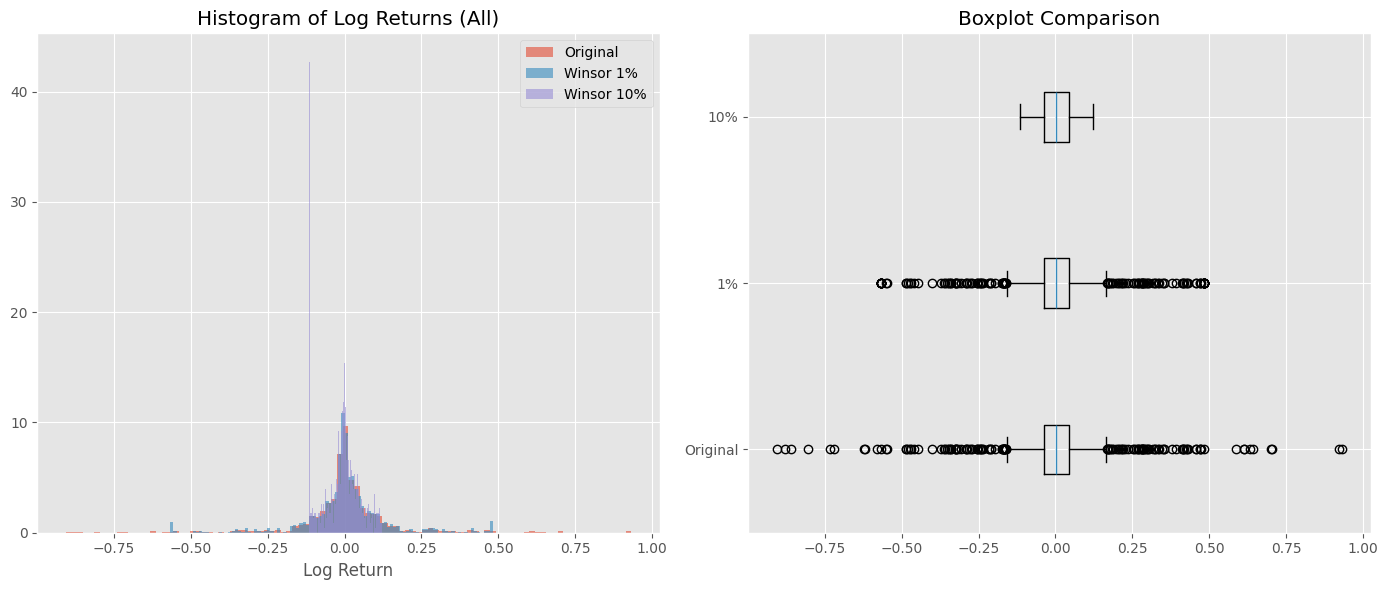

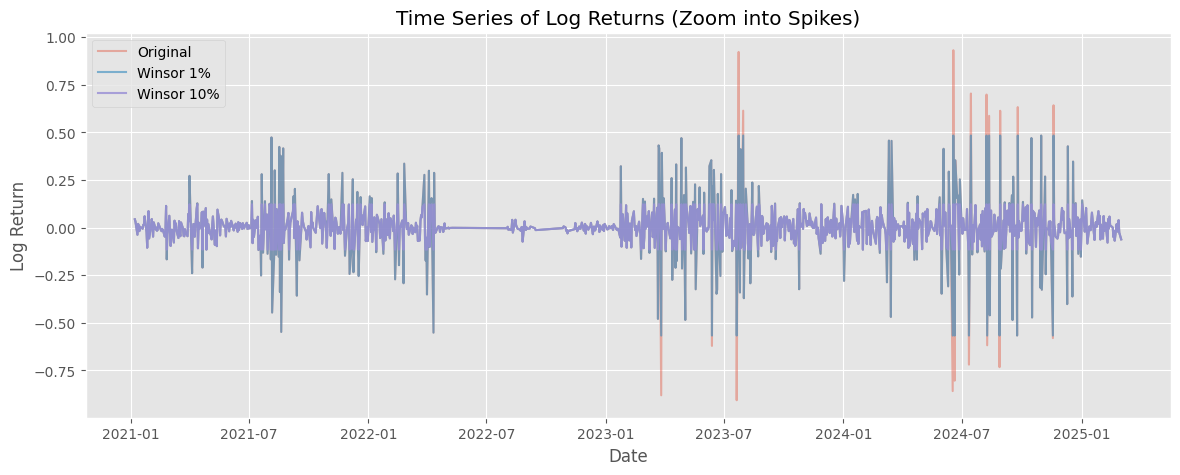

------ Skewness ------
Original   : -0.2256352997133147
Winsor 1%  : -0.316203210233094
Winsor 10% : 0.019717220616182193

------ Kurtosis ------
Original   : 9.371563200617002
Winsor 1%  : 4.948793292168652
Winsor 10% : -0.6408398695017969

------ Clipped Values Count ------
Winsor 1%  : 18 values changed
Winsor 10% : 190 values changed


In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# === Inputs ===
original = log_returns
clip_01 = pd.Series(winsorize(log_returns, limits=[0.01,0.01]), index=log_returns.index)
clip_001 = pd.Series(winsorize(log_returns, limits=[0.1,0.1]), index=log_returns.index)

# === 1. Histogram Comparison ===
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(original, bins=100, alpha=0.6, label='Original', density=True)
plt.hist(clip_01, bins=100, alpha=0.6, label='Winsor 1%', density=True)
plt.hist(clip_001, bins=100, alpha=0.6, label='Winsor 10%', density=True)
plt.legend()
plt.title('Histogram of Log Returns (All)')
plt.xlabel('Log Return')

plt.subplot(1, 2, 2)
plt.boxplot([original, clip_01, clip_001], vert=False, labels=['Original', '1%', '10%'])
plt.title('Boxplot Comparison')

plt.tight_layout()
plt.show()

# === 2. Time Series Comparison ===
plt.figure(figsize=(14, 5))
plt.plot(original.index, original, label='Original', alpha=0.4)
plt.plot(clip_01.index, clip_01, label='Winsor 1%', alpha=0.6)
plt.plot(clip_001.index, clip_001, label='Winsor 10%', alpha=0.8)
plt.legend()
plt.title('Time Series of Log Returns (Zoom into Spikes)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

# === 3. Skewness and Kurtosis ===
print("------ Skewness ------")
print("Original   :", skew(original))
print("Winsor 1%  :", skew(clip_01))
print("Winsor 10% :", skew(clip_001))

print("\n------ Kurtosis ------")
print("Original   :", kurtosis(original))
print("Winsor 1%  :", kurtosis(clip_01))
print("Winsor 10% :", kurtosis(clip_001))

# === 4. Count of Clipped Values ===
clipped_vals_01 = (original != clip_01).sum()
clipped_vals_001 = (original != clip_001).sum()

print("\n------ Clipped Values Count ------")
print(f"Winsor 1%  : {clipped_vals_01} values changed")
print(f"Winsor 10% : {clipped_vals_001} values changed")


In [166]:
skew(original)

-0.2256352997133147

In [169]:
skew(equity2.Total.pct_change().dropna())

2.55775107915951

In [163]:
log_returns.reindex(range(0, len(log_returns)), method='ffill')

TypeError: Cannot compare dtypes datetime64[ns] and int64